In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from helper.lazy_regression import TooLazyForRegression
from helper.feature_extract import extract_highest_amplitude_features_with_mp,feature_extractor_wrapper
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

In [2]:
#Import data
df_mpa = pd.read_table('../data/data_mpa.txt', sep=' ')
df_mpa = extract_highest_amplitude_features_with_mp(df=df_mpa, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_spg = pd.read_table('../data/data_spg.txt', sep=' ')
df_spg = extract_highest_amplitude_features_with_mp(df=df_spg, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_sps = pd.read_table('../data/data_sps.txt', sep=' ')
df_sps = extract_highest_amplitude_features_with_mp(df=df_sps, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)

INFO || Extracting Max Features for types: ['M03', 'M01', 'M04', 'M02']
INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['M01']
INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['S01']


In [2]:
df_mpa = pd.read_table('../data/data_mpa.txt', sep=' ')
df_mpa = feature_extractor_wrapper(df_mpa, extract_max_features=True, extract_mean_features=True)

INFO || Extracting Mean Features
INFO || Extracting Max Features for types: ['M03', 'M02', 'M01', 'M04']


In [3]:
df_spg = pd.read_table('../data/data_spg.txt', sep=' ')
df_spg = feature_extractor_wrapper(df_spg, extract_max_features=True, extract_mean_features=True)

INFO || Extracting Mean Features
INFO || Extracting Max Features for types: ['G01', 'G02']


In [4]:
def Year_splitter(df):
    df_2018 = df[df['start_time'].str.contains('2018')]
    df_2018 = df_2018.drop(["start_time","packnr","velocity"], axis=1)
    df_2019 = df[df['start_time'].str.contains('2019')]
    df_2019 = df_2019.drop(["start_time","packnr","velocity"], axis=1)
    df_2020 = df[df['start_time'].str.contains('2020')]
    df_2020 = df_2020.drop(["start_time","packnr","velocity"], axis=1)
    df_2021 = df[df['start_time'].str.contains('2021')]
    df_2021 = df_2021.drop(["start_time","packnr","velocity"], axis=1)
    
    df_2019_2020_frames = [df_2019, df_2020]
    df_2019_2020 = pd.concat(df_2019_2020_frames)
    df_2019_2021_frames = [df_2019, df_2021]
    df_2019_2021 = pd.concat(df_2019_2021_frames)
    df_2020_2021_frames = [df_2020, df_2021]
    df_2020_2021 = pd.concat(df_2020_2021_frames)
    return df_2018,df_2019,df_2020,df_2021,df_2019_2020,df_2019_2021,df_2020_2021

In [5]:
df_mpa_2018,df_mpa_2019,df_mpa_2020,df_mpa_2021,df_mpa_2019_2020,df_mpa_2019_2021,df_mpa_2020_2021 = Year_splitter(df_mpa)
df_spg_2018,df_spg_2019,df_spg_2020,df_spg_2021,df_spg_2019_2020,df_spg_2019_2021,df_spg_2020_2021 = Year_splitter(df_spg)

# MPA 

In [8]:
def model_scorer(folds,X,y):
    scores = []
    for i in range(folds):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
        model= CatBoostRegressor(verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_pred,y_test)
        scores.append(r2)
    return scores

In [9]:
def to_df(liste,name):
    df_trans = pd.DataFrame(liste)
    df_trans["transformation"] = name
    return df_trans

In [10]:
fold = 10
X, y = df_mpa_2018.drop(['size_mm'], axis=1), df_mpa_2018['size_mm']
mpa_2018_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_mpa_2019.drop(['size_mm'], axis=1), df_mpa_2019['size_mm']
mpa_2019_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_mpa_2020.drop(['size_mm'], axis=1), df_mpa_2020['size_mm']
mpa_2020_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_mpa_2021.drop(['size_mm'], axis=1), df_mpa_2021['size_mm']
mpa_2021_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_mpa_2019_2020.drop(['size_mm'], axis=1), df_mpa_2019_2020['size_mm']
mpa_2019_2020_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_mpa_2019_2021.drop(['size_mm'], axis=1), df_mpa_2019_2021['size_mm']
mpa_2019_2021_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_mpa_2020_2021.drop(['size_mm'], axis=1), df_mpa_2020_2021['size_mm']
mpa_2020_2021_scores = model_scorer(folds=fold,X=X,y=y)

In [11]:
df_mpa = df_mpa.drop(["start_time","packnr","velocity"], axis=1)
X, y = df_mpa.drop(['size_mm'], axis=1), df_mpa['size_mm']
mpa_all_scores = model_scorer(folds=fold,X=X,y=y)

In [12]:
df_mpa_2018_scores = to_df(mpa_2018_scores,"mpa_2018")
df_mpa_2019_scores = to_df(mpa_2019_scores,"mpa_2019")
df_mpa_2020_scores = to_df(mpa_2020_scores,"mpa_2020")
df_mpa_2021_scores = to_df(mpa_2021_scores,"mpa_2021")
df_mpa_2019_2020_scores = to_df(mpa_2019_2020_scores,"mpa_2019_2020")
df_mpa_2019_2021_scores = to_df(mpa_2019_2021_scores,"mpa_2019_2021")
df_mpa_2020_2021_scores = to_df(mpa_2020_2021_scores,"mpa_2020_2021")
df_mpa_all_scores = to_df(mpa_all_scores,"alle_Jahre")

In [13]:
mpa_dfs = [df_mpa_2018_scores,df_mpa_2019_scores,df_mpa_2020_scores,df_mpa_2021_scores,df_mpa_2019_2020_scores,df_mpa_2019_2021_scores,df_mpa_2020_2021_scores,df_mpa_all_scores]
result = pd.concat(mpa_dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

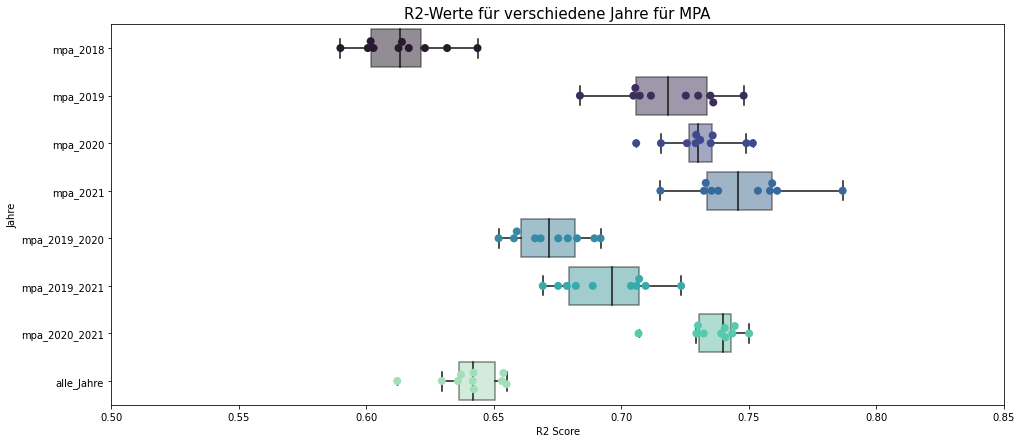

In [14]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5),palette="mako")
p = sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],s=8,palette="mako")
#p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Jahre für MPA",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.85])
plt.ylabel("Jahre")
plt.show()

# SPG 

In [15]:
fold = 10
X, y = df_spg_2018.drop(['size_mm'], axis=1), df_spg_2018['size_mm']
spg_2018_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_spg_2019.drop(['size_mm'], axis=1), df_spg_2019['size_mm']
spg_2019_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_spg_2020.drop(['size_mm'], axis=1), df_spg_2020['size_mm']
spg_2020_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_spg_2021.drop(['size_mm'], axis=1), df_spg_2021['size_mm']
spg_2021_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_spg_2019_2020.drop(['size_mm'], axis=1), df_spg_2019_2020['size_mm']
spg_2019_2020_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_spg_2019_2021.drop(['size_mm'], axis=1), df_spg_2019_2021['size_mm']
spg_2019_2021_scores = model_scorer(folds=fold,X=X,y=y)
X, y = df_spg_2020_2021.drop(['size_mm'], axis=1), df_spg_2020_2021['size_mm']
spg_2020_2021_scores = model_scorer(folds=fold,X=X,y=y)

In [16]:
df_spg = df_spg.drop(["start_time","packnr","velocity"], axis=1)
X, y = df_spg.drop(['size_mm'], axis=1), df_spg['size_mm']
spg_all_scores = model_scorer(folds=fold,X=X,y=y)

In [17]:
df_spg_2018_scores = to_df(spg_2018_scores,"spg_2018")
df_spg_2019_scores = to_df(spg_2019_scores,"spg_2019")
df_spg_2020_scores = to_df(spg_2020_scores,"spg_2020")
df_spg_2021_scores = to_df(spg_2021_scores,"spg_2021")
df_spg_2019_2020_scores = to_df(spg_2019_2020_scores,"spg_2019_2020")
df_spg_2019_2021_scores = to_df(spg_2019_2021_scores,"spg_2019_2021")
df_spg_2020_2021_scores = to_df(spg_2020_2021_scores,"spg_2020_2021")
df_spg_all_scores = to_df(spg_all_scores,"alle_Jahre")

In [18]:
spg_dfs = [df_spg_2018_scores,df_spg_2019_scores,df_spg_2020_scores,df_spg_2021_scores,df_spg_2019_2020_scores,df_spg_2019_2021_scores,df_spg_2020_2021_scores,df_spg_all_scores]
result = pd.concat(spg_dfs)
result = result.rename(columns={ result.columns[0]: "r2" })

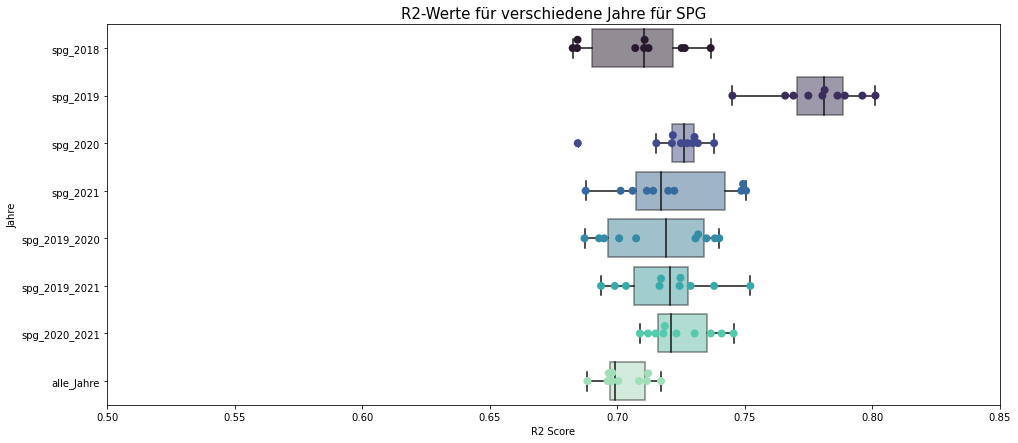

In [19]:
plot_data = result
fig = plt.subplots(figsize=(16, 7))

p =sns.boxplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"], boxprops=dict(alpha=.5),palette="mako")
p = sns.swarmplot(data=plot_data,x=plot_data["r2"],y=plot_data["transformation"],s=8,palette="mako")
#p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=6, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Jahre für SPG",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0.5,0.85])
plt.ylabel("Jahre")
plt.show()